In [115]:
import numpy as np
import pandas as pd
import category_encoders as ce
import seaborn as sns
from random import sample
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from statistics import stdev

In [89]:
# because most encodings don't even work on the full dataset cause OOM
data = pd.read_csv('allegro-api-transactions.csv')

In [20]:
data.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


# Kodowanie zmiennych kategorycznych

In [24]:
x = data.it_location
x

0                    Warszawa
1                    Warszawa
2                      Leszno
3         Wola Krzysztoporska
4                   BIAŁYSTOK
                 ...         
420015                Kraśnik
420016            Dzierżoniów
420017                Supraśl
420018                 Poznań
420019                  Pszów
Name: it_location, Length: 420020, dtype: object

In [50]:
target = ce.TargetEncoder(cols=['it_location'])
onehot = ce.OneHotEncoder(cols=['it_location'])

In [39]:
x = data.drop(columns=["price"],axis=1)
y = data.price

In [52]:
try:
    onehot.fit(x,y)
except MemoryError as e:
    print('OOM!', e)

/home/mtizim/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
OOM! Unable to allocate 31.5 GiB for an array with shape (420020, 10056) and data type int64


In [46]:
targetfitted = target.fit(x,y).transform(x).it_location
targetfitted

/home/mtizim/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0          85.423398
1          85.423398
2          61.990914
3          35.433365
4         117.191956
             ...    
420015     24.306929
420016     66.785334
420017     18.682800
420018    106.203076
420019     78.136792
Name: it_location, Length: 420020, dtype: float64

In [48]:
print(len(targetfitted.unique()),len(data.it_location.unique()))

6284 10056


Jak widać powyżej - one hot encoding na takiej ilości różnych zmiennych nawet nie mieści się w mojej pamięci, a co dopiero mówić o wykonwywaniu na nim operacji macierzowych.

W porównaniu do tego - target encoding zachowuje się znacznie lepiej, dodatkowo pokazując wpływ danej kategorii na target. Niestety, w wypadku takim jak powyżej, gdzie jest sporo kategorii z porównywalnym wpływem na target, tracimy sporą część informacji o kategoriach - mamy mniej unikatowych wartości

In [60]:
leaveone = ce.LeaveOneOutEncoder(cols=['main_category'])
ordinal = ce.OrdinalEncoder(cols=['main_category'])

In [78]:
 od = ordinal.fit(x).transform(x).main_category
 od

/home/mtizim/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0         1
1         2
2         3
3         4
4         2
         ..
420015    6
420016    9
420017    2
420018    8
420019    7
Name: main_category, Length: 420020, dtype: int64

Encoder ordinal jest tak samo użyteczny jak label encoder, czyli wcale. Jedyne miejsce gdzie może znaleźć zastosowanie, to encoding zmiennej, której wartości są w jakiś sposób uporządkowane

In [66]:
l = leaveone.fit(x,y).transform(x).main_category
l

0         121.810064
1          75.858049
2          72.434754
3          25.027497
4          75.858049
             ...    
420015    107.534272
420016     28.128577
420017     75.858049
420018     71.206386
420019    134.426801
Name: main_category, Length: 420020, dtype: float64

In [67]:
print(len(l.unique()),len(data.main_category.unique())) 

27 27


Nie tracimy żadnych informacji o zbiorze

Leave one out encoding jest bardzo podobny do target encoding - podczas obliczeń robi dokładnie to samo, z pominięciem targetu w wierszu dla którego jest liczona średnia. Ma te same wady, ale jest trochę bardziej odporny na outliery

In [71]:
o = ce.OneHotEncoder(cols=['main_category']).fit(x).transform(x)
o.columns

/home/mtizim/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Index(['lp', 'date', 'item_id', 'categories', 'pay_option_on_delivery',
       'pay_option_transfer', 'seller', 'it_is_allegro_standard',
       'it_quantity', 'it_is_brand_zone', 'it_seller_rating', 'it_location',
       'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'main_category_16', 'main_category_17', 'main_category_18',
       'main_category_19', 'main_category_20', 'main_category_21',
       'main_category_22', 'main_category_23', 'main_category_24',
       'main_category_25', 'main_category_26', 'main_category_27'],
      dtype='object')

Dużo kolumn, ale to jeszcze rozsądna ilość

<AxesSubplot:xlabel='main_category', ylabel='Count'>

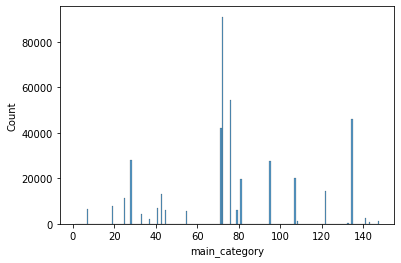

In [76]:
sns.histplot(l)

<AxesSubplot:xlabel='main_category', ylabel='Count'>

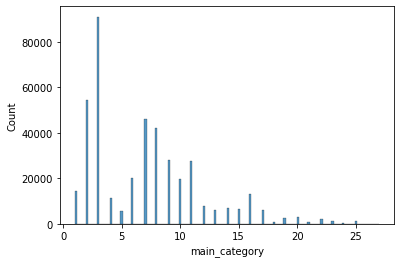

In [79]:
sns.histplot(od)

Widzimy podobny rozkład co w przypadku leave one out, tylko że w przypadku ordinal jest jemu nadana interpretacja kolejnościowa, której nie ma.

# Uzupełnianie braków

In [134]:
rmse = lambda x,y: mean_squared_error(x,y,squared=False)

In [101]:
# Tworzymy braki
data = pd.read_csv('allegro-api-transactions.csv',nrows=10000)
data = data[["it_seller_rating","it_quantity"]]
original = data.copy(deep=True)
idx = sample(list(range(len(data))),len(data)//10)
data.loc[idx,'it_seller_rating'] = np.nan

In [110]:
data

,it_seller_rating,it_quantity
0,50177.0,997
1,12428.0,9288
2,7389.0,895
3,15006.0,971
4,32975.0,950
...,...,...
9995,22866.0,628
9996,110.0,9833
9997,110.0,9833
9998,110.0,9833


In [102]:
imputer = KNNImputer(n_neighbors = 3,weights = 'uniform')

In [132]:
transformed = imputer.fit_transform(data)

0       50177
1       12428
2        7389
3       15006
4       32975
        ...  
9995    22866
9996      110
9997      110
9998      110
9999      110
Name: it_seller_rating, Length: 10000, dtype: int64

In [112]:
rmse(transformed[:,0],original.it_seller_rating)

11994.897981087162

Całkiem nienajlepiej

Dla dziesięciu powtórzeń odchylnie standardowe jest całkiem niestabilne, powtarzam 100 razy

In [139]:
s = []
for _ in range(100):
    data = pd.read_csv('allegro-api-transactions.csv',nrows=10000)
    data = data[["price","it_seller_rating","it_quantity"]]
    original = data.copy(deep=True)
    idx = sample(list(range(len(data))),len(data)//10)
    data.loc[idx,'it_seller_rating'] = np.nan
    imputer = KNNImputer(n_neighbors = 3,weights = 'uniform')
    transformed = imputer.fit_transform(data)
    s += [rmse(transformed[:,0],original.it_seller_rating)]
stdev(s)

0.0

In [140]:
s2 = []
for _ in range(100):
    data = pd.read_csv('allegro-api-transactions.csv',nrows=10000)
    data = data[["price","it_seller_rating","it_quantity"]]
    original = data.copy(deep=True)
    idx = sample(list(range(len(data))),len(data)//10)
    idx2 = sample(list(range(len(data))),len(data)//10)
    data.loc[idx,'it_seller_rating'] = np.nan
    data.loc[idx,'it_quantity'] = np.nan
    imputer = KNNImputer(n_neighbors = 3,weights = 'uniform')
    transformed = imputer.fit_transform(data)
    s2 += [rmse(transformed,original)]
stdev(s2)

264.82373155583406

40819.85642987169


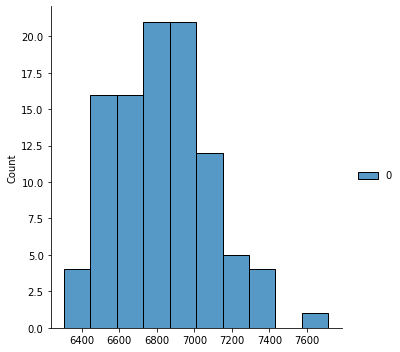

In [143]:
print(s[0])
sns.displot([s2])

Jak widać, usunięcie drugiej kolumny wprowadza znacząco większy błąd - algorytm imputacyjny dysponuje mniejszą ilością danych, więc średnio wychodzą mu gorsze przybliżenia danych oryginalnych - jak można było się spodziewać